## Análisis del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2       # Para leer imágenes y matchTemplate
import os        # Para os.path.exists
import numpy as np  # Opcional, si vas a manipular arrays (ej. máscaras)
from torchvision import models

In [3]:
path_meta = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/meta.csv'
path_dicom = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/dicom_info.csv'
path_calcification_test = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/calc_case_description_test_set.csv'
path_calcification_train = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/calc_case_description_train_set.csv'
path_mass_test = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/mass_case_description_test_set.csv'
path_mass_train = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/mass_case_description_train_set.csv'
path_mass_val = 'C:/Users/Itziar/Documents/Documentos/TFG-INF-DATOS/archive/csv/mass_case_description_val_set.csv'
root = 'C:\\Users\\Itziar\\Documents\\Documentos\\TFG-INF-DATOS\\archive\\jpeg'

In [4]:

mass_test_data = pd.read_csv(path_mass_test)
mass_train_data = pd.read_csv(path_mass_train)
len(mass_train_data)


982

In [13]:
num_benign = (mass_train_data['pathology'] == 'BENIGN').sum()
print("Número de casos BENIGN:", num_benign)
num_benign = (mass_train_data['pathology'] == 'MALIGNANT').sum()
print("Número de casos BENIGN:", num_benign)
num_benign = (mass_test_data['pathology'] == 'BENIGN').sum()
print("Número de casos BENIGN:", num_benign)
num_benign = (mass_test_data['pathology'] == 'MALIGNANT').sum()
print("Número de casos BENIGN:", num_benign)

Número de casos BENIGN: 609
Número de casos BENIGN: 617
Número de casos BENIGN: 220
Número de casos BENIGN: 147


In [4]:
for df in [mass_train_data, mass_test_data]:
    if 'pathology' in df.columns:
        df['pathology'] = df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')


In [7]:
mass_train_data['pathology'].unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [71]:
mass_test_data = pd.read_csv(path_mass_test)
mass_train_data = pd.read_csv(path_mass_train)
mass_test_data.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                             cropped image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                                  ROI mask file path   x_min   y_min   x_max  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   250.0  2402.0   681.0   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   251.0  2960.0   507.0   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1397.0  3480.0  1820.0   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1633.0  3035.0  2055.0   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   674.0  3784.0  1139.0   

    y_max  
0  2917.0  
1  3252.0  
2  3946.0  
3  3462.0  
4  4183.0

In [ ]:
mass_train_data['pathology'].unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [ ]:
mass_test_data['pathology'] = mass_test_data['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

In [16]:

# --- Hacemos copia de todas las columnas ---
train_df = mass_train_data.copy()  # Para no modificar el original
val_df = pd.DataFrame(columns=train_df.columns)  # DataFrame vacío con mismas columnas

# --- Número de casos por clase para validación ---
num_val_per_class = 122 # en tu ejemplo real serían 122

# --- Seleccionamos filas BENIGN y MALIGNANT ---
benign_val = train_df[train_df['pathology'] == 'BENIGN'].sample(n=num_val_per_class, random_state=42)
malignant_val = train_df[train_df['pathology'] == 'MALIGNANT'].sample(n=num_val_per_class, random_state=42)

# --- Concatenamos al DataFrame de validación ---
val_df = pd.concat([val_df, benign_val, malignant_val])

# --- Eliminamos esas filas del DataFrame de entrenamiento ---
train_df = train_df.drop(benign_val.index)
train_df = train_df.drop(malignant_val.index)

# --- Reiniciamos índices si queremos ---
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# --- Comprobación ---
print("Train:")
print(train_df)
print("\nValidation:")
print(val_df)


Train:
    patient_id  breast_density left or right breast image view  \
0      P_00001               3                 LEFT         CC   
1      P_00001               3                 LEFT        MLO   
2      P_00004               3                 LEFT         CC   
3      P_00004               3                 LEFT        MLO   
4      P_00009               3                RIGHT        MLO   
..         ...             ...                  ...        ...   
977    P_01887               2                 LEFT        MLO   
978    P_01888               2                RIGHT        MLO   
979    P_01889               1                RIGHT         CC   
980    P_01889               1                RIGHT        MLO   
981    P_01946               2                RIGHT         CC   

     abnormality id abnormality type                          mass shape  \
0                 1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                 1             mass  IRREGULAR-

C:\Users\Itziar\AppData\Local\Temp\ipykernel_19136\3863786556.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_df = pd.concat([val_df, benign_val, malignant_val])


In [20]:
num_benign = (train_df['pathology'] == 'BENIGN').sum()
print("Número de casos BENIGN:", num_benign)
num_benign = (train_df['pathology'] == 'MALIGNANT').sum()
print("Número de casos MALIGNANT:", num_benign)
num_benign = (val_df['pathology'] == 'BENIGN').sum()
print("Número de casos BENIGN:", num_benign)
num_benign = (val_df['pathology'] == 'MALIGNANT').sum()
print("Número de casos MALIGNANT:", num_benign)

Número de casos BENIGN: 487
Número de casos MALIGNANT: 495
Número de casos BENIGN: 122
Número de casos MALIGNANT: 122


In [22]:
train_df.to_csv(path_mass_train,index=False)
val_df.to_csv(path_mass_val,index=False)

In [ ]:
mass_test_data['pathology'].unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [ ]:
mass_test_data.to_csv(path_mass_test, index=False)

In [ ]:
mass_train_data['pathology'].unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [ ]:
contar_patologias(mass_train_data)

{'BENIGN': 510, 'MALIGNANT': 617, 'BENIGN_WITHOUT_CALLBACK': 99}

In [ ]:
contar_patologias(mass_test_data)

{'BENIGN': 183, 'MALIGNANT': 147, 'BENIGN_WITHOUT_CALLBACK': 37}

In [ ]:
mass_train_data

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1313    P_02033               2                RIGHT        MLO   
1314    P_02079               2                RIGHT         CC   
1315    P_02079               2                RIGHT        MLO   
1316    P_02092               2                 LEFT         CC   
1317    P_02092               2                 LEFT        MLO   

      abnormality id abnormality type                          mass shape  \
0                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
2                  1             mass            ARCHITECTURAL_DISTORTION   
3                  1             mass            ARCHITECTURAL_DISTORTION   
4                  1             mass                                OVAL   
...              ...              ...                                 ...   
1313               1             mass                           IRREGULAR   
1314               1             mass                               ROUND   
1315               1             mass                               ROUND   
1316               1             mass                           IRREGULAR   
1317               1             mass                           IRREGULAR   

       mass margins  assessment  pathology  subtlety  \
0        SPICULATED           4  MALIGNANT         4   
1        SPICULATED           4  MALIGNANT         4   
2       ILL_DEFINED           4     BENIGN         3   
3       ILL_DEFINED           4     BENIGN         3   
4     CIRCUMSCRIBED           4     BENIGN         5   
...             ...         ...        ...       ...   
1313    ILL_DEFINED           3  MALIGNANT         4   
1314     SPICULATED           3  MALIGNANT         5   
1315     SPICULATED           3  MALIGNANT         5   
1316     SPICULATED           3  MALIGNANT         2   
1317     SPICULATED           3  MALIGNANT         2   

                                        image file path  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   
...                                                 ...   
1313  Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...   
1314  Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...   
1315  Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...   
1316  Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...   
1317  Mass-Training_P_02092_LEFT_MLO/1.3.6.1.4.1.959...   

                                cropped image file path  \
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2     Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3     Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4     Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   
...                                                 ...   
1313  Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....   
1314  Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...   
1315  Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....   
1316  Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...   
1317  Mass-Training_P_02092_LEFT_MLO_1/1.3.6.1.4.1.9...   

                                     ROI mask file path  
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2     Mass

In [ ]:
mass_train_data['mass shape'].unique()

array(['IRREGULAR-ARCHITECTURAL_DISTORTION', 'ARCHITECTURAL_DISTORTION',
       'OVAL', 'IRREGULAR', 'LYMPH_NODE', 'LOBULATED-LYMPH_NODE',
       'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ROUND',
       'LOBULATED-ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'LOBULATED-IRREGULAR', nan, 'OVAL-LYMPH_NODE', 'LOBULATED-OVAL',
       'ROUND-OVAL', 'IRREGULAR-FOCAL_ASYMMETRIC_DENSITY',
       'ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION', 'ROUND-LOBULATED'],
      dtype=object)

In [ ]:
mass_train_data


patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1313    P_02033               2                RIGHT        MLO   
1314    P_02079               2                RIGHT         CC   
1315    P_02079               2                RIGHT        MLO   
1316    P_02092               2                 LEFT         CC   
1317    P_02092               2                 LEFT        MLO   

      abnormality id abnormality type                          mass shape  \
0                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
2                  1             mass            ARCHITECTURAL_DISTORTION   
3                  1             mass            ARCHITECTURAL_DISTORTION   
4                  1             mass                                OVAL   
...              ...              ...                                 ...   
1313               1             mass                           IRREGULAR   
1314               1             mass                               ROUND   
1315               1             mass                               ROUND   
1316               1             mass                           IRREGULAR   
1317               1             mass                           IRREGULAR   

       mass margins  assessment  pathology  subtlety  \
0        SPICULATED           4  MALIGNANT         4   
1        SPICULATED           4  MALIGNANT         4   
2       ILL_DEFINED           4     BENIGN         3   
3       ILL_DEFINED           4     BENIGN         3   
4     CIRCUMSCRIBED           4     BENIGN         5   
...             ...         ...        ...       ...   
1313    ILL_DEFINED           3  MALIGNANT         4   
1314     SPICULATED           3  MALIGNANT         5   
1315     SPICULATED           3  MALIGNANT         5   
1316     SPICULATED           3  MALIGNANT         2   
1317     SPICULATED           3  MALIGNANT         2   

                                        image file path  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   
...                                                 ...   
1313  Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...   
1314  Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...   
1315  Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...   
1316  Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...   
1317  Mass-Training_P_02092_LEFT_MLO/1.3.6.1.4.1.959...   

                                cropped image file path  \
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2     Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3     Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4     Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   
...                                                 ...   
1313  Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....   
1314  Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...   
1315  Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....   
1316  Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...   
1317  Mass-Training_P_02092_LEFT_MLO_1/1.3.6.1.4.1.9...   

                                     ROI mask file path  
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2     Mass

In [15]:
import os
import shutil
from PIL import Image
import numpy as np

def procesar_directorio(directorio, df, idx, umbral_negros=0.9):
    """
    Procesa un directorio con dos imágenes:
    - Si no existe o no contiene dos imágenes, elimina la fila correspondiente del DataFrame.
    - Si tiene dos imágenes, identifica la ROI mask (más píxeles negros) y renombra:
        - 1.jpeg -> imagen original
        - 2.jpeg -> ROI mask

    Args:
        directorio (str): Ruta del directorio a analizar.
        df (pd.DataFrame): DataFrame donde eliminar la fila si la carpeta falla.
        idx (int): Índice de la fila correspondiente en el DataFrame.
        umbral_negros (float): Umbral para considerar una imagen como ROI mask.
    
    Returns:
        pd.DataFrame: DataFrame actualizado (sin la fila si hubo error).
    """
    # Verificar existencia del directorio
    if not os.path.exists(directorio):
        print(f"❌ Carpeta no encontrada: {directorio}. Eliminando fila {idx}.")
        df = df.drop(idx)
        return df

    try:
        archivos = [f for f in os.listdir(directorio) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    except FileNotFoundError:
        print(f"❌ No se pudo acceder a '{directorio}'. Eliminando fila {idx}.")
        df = df.drop(idx)
        return df

    # Si no hay exactamente dos imágenes → eliminar carpeta y fila
    if len(archivos) != 2:
        print(f"⚠️ Carpeta '{directorio}' eliminada: contiene {len(archivos)} imágenes.")
        shutil.rmtree(directorio, ignore_errors=True)
        df = df.drop(idx)
        return df

    archivos.sort()
    porcentajes_negros = []

    # Calcular porcentaje de píxeles negros en cada imagen
    for archivo in archivos:
        imagen_path = os.path.join(directorio, archivo)
        with Image.open(imagen_path).convert('L') as img:
            arr = np.array(img)
            total_pixeles = arr.size
            negros = np.sum(arr == 0)
            porcentaje_negros = negros / total_pixeles
            porcentajes_negros.append(porcentaje_negros)
            print(f"🖼️ '{archivo}': {porcentaje_negros:.2%} píxeles negros")

    # Determinar cuál es la ROI mask
    idx_mask = np.argmax(porcentajes_negros)
    idx_original = 1 - idx_mask

    # Renombrar ambas imágenes
    img_mask = archivos[idx_mask]
    img_original = archivos[idx_original]

    path_mask = os.path.join(directorio, img_mask)
    path_original = os.path.join(directorio, img_original)

    os.rename(path_mask, os.path.join(directorio, "2.jpeg"))
    os.rename(path_original, os.path.join(directorio, "1.jpeg"))

    print(f"✅ '{img_mask}' → 2.jpeg (mask)")
    print(f"✅ '{img_original}' → 1.jpeg (original)")

    return df


In [58]:
import os
import pandas as pd

# Cargar los CSV
mass_test_data = pd.read_csv(path_mass_test)
mass_train_data = pd.read_csv(path_mass_train)
# Crear una copia para iterar
df_train = mass_train_data.copy()
df_test = mass_test_data.copy()

for idx, fila in df_train.iterrows():
    path = fila['ROI mask file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_train_data = procesar_directorio(folder, mass_train_data, idx)

for idx, fila in df_test.iterrows():
    path = fila['ROI mask file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_test_data = procesar_directorio(folder, mass_test_data, idx)
# === Reestablecer índices y sobrescribir los CSV ===
mass_train_data.reset_index(drop=True, inplace=True)
mass_test_data.reset_index(drop=True, inplace=True)



print("✅ Procesamiento completo. CSV actualizados y limpiados.")    

🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 98.96% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.49% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.90% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.89% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.45% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.27% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.40% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.jpeg (original)
🖼️ '1.jpeg': 0.00% píxeles negros
🖼️ '2.jpeg': 99.00% píxeles negros
✅ '2.jpeg' → 2.jpeg (mask)
✅ '1.jpeg' → 1.

In [ ]:
mass_train_data.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [ ]:
mass_train_data.to_csv(path_calcification_train, index=False)
mass_test_data.to_csv(path_calcification_test, index=False)

In [ ]:
mass_train_data.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                             cropped image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                                  ROI mask file path x_min y_min x_max y_max  
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1565  2649  2242  3238  
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1520  3274  2201  3823  
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1396  1240  1973  1921  
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1144  2552  1905  3241  
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1548  1884  1725  2045

In [ ]:
print(mass_train_data.loc[0,'image file path'])
print(mass_train_data.loc[0,'cropped image file path'])

Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm
Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm


In [ ]:
mass_test_data = pd.read_csv(path_mass_test)
mass_train_data = pd.read_csv(path_mass_train)
path = mass_test_data.loc[0, 'ROI mask file path'].split('/')
folder = os.path.join(root, path[-2])  # os.path.join (no os.join)
print(mass_test_data.loc[0, 'ROI mask file path'])
procesar_directorio(folder)


Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.259596319110047779433501728143778409887/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/000001.dcm

Imagen '2-272.jpg': 0.00% píxeles negros
Imagen '2.jpeg': 98.96% píxeles negros
✅ '2.jpeg' → 2.jpeg  (mask)
✅ '2-272.jpg' → 1.jpeg (original)


In [ ]:
mass_test_data = pd.read_csv(path_calcification_test)
mass_train_data = pd.read_csv(path_calcification_train)

In [19]:
import os
import shutil
from PIL import Image
import numpy as np

def procesar_directorio2(directorio, df, idx):
    # Verificar existencia del directorio
    if not os.path.exists(directorio):
        print(f"❌ Carpeta no encontrada: {directorio}. Eliminando fila {idx}.")
        df = df.drop(idx)
        return df

    try:
        archivos = [f for f in os.listdir(directorio) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    except Exception as e:
        print(f"❌ No se pudo acceder a '{directorio}' ({e}). Eliminando fila {idx}.")
        df = df.drop(idx)
        return df

    # Si no hay exactamente una imagen → eliminar carpeta y fila
    if len(archivos) != 1:
        print(f"⚠️ Carpeta '{directorio}' eliminada: contiene {len(archivos)} imágenes.")
        shutil.rmtree(directorio, ignore_errors=True)
        df = df.drop(idx)
        return df

    # Renombrar la única imagen a "0.jpeg"
    imagen_original = os.path.join(directorio, archivos[0])
    imagen_nueva = os.path.join(directorio, "0.jpeg")

    try:
        os.rename(imagen_original, imagen_nueva)
        print(f"✅ '{imagen_original}' renombrada a '0.jpeg'")
    except Exception as e:
        print(f"❌ Error al renombrar '{imagen_original}': {e}")
        shutil.rmtree(directorio, ignore_errors=True)
        df = df.drop(idx)

    return df


In [ ]:
import os
import pandas as pd

# Crear una copia para iterar
df_train = mass_train_data.copy()
df_test = mass_test_data.copy()

for idx, fila in df_train.iterrows():
    path = fila['image file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_train_data = procesar_directorio2(folder, mass_train_data, idx)

for idx, fila in df_test.iterrows():
    path = fila['image file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_test_data = procesar_directorio2(folder, mass_test_data, idx)
# === Reestablecer índices y sobrescribir los CSV ===
mass_train_data.reset_index(drop=True, inplace=True)
mass_test_data.reset_index(drop=True, inplace=True)

print("✅ Procesamiento completo. CSV actualizados y limpiados.")    

✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\

In [55]:
import os
import pandas as pd

# Cargar los CSV
mass_train_data = pd.read_csv(path_mass_test)
mass_test_data = pd.read_csv(path_mass_train)
# Crear una copia para iterar
df_train = mass_train_data.copy()
df_test = mass_test_data.copy()

for idx, fila in df_train.iterrows():
    path = fila['image file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_train_data = procesar_directorio2(folder, mass_train_data, idx)

for idx, fila in df_test.iterrows():
    path = fila['image file path'].split('/')
    folder = os.path.join(root, path[-2])
    mass_test_data = procesar_directorio2(folder, mass_test_data, idx)
# === Reestablecer índices y sobrescribir los CSV ===
mass_train_data.reset_index(drop=True, inplace=True)
mass_test_data.reset_index(drop=True, inplace=True)


print("✅ Procesamiento completo. CSV actualizados y limpiados.")    

✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.85952214611170506017891429690540035518\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.22131189612893294827907969600765582967\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.239949064412092068706566726490415129934\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.215081818713600536113960661873725083371\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.318799084911119262430780458250312419361\0.jpeg' renombrada a '0.jpeg'
✅ 'C:\Users\Itziar\Documents\D

In [ ]:
mass_train_data.to_csv(path_calcification_train, index=False)
mass_test_data.to_csv(path_calcification_test, index=False)


In [49]:
for df in [mass_train_data, mass_test_data]:
    df['x_min'] = None
    df['y_min'] = None
    df['x_max'] = None
    df['y_max'] = None

In [50]:
mass_test_data.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image file path  \
0  Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...   
3  Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...   
4  Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...   

                             cropped image file path  \
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

                                  ROI mask file path x_min y_min x_max y_max  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  None  None  None  None  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  None  None  None  None  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  None  None  None  None  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  None  None  None  None  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....  None  None  None  None

In [37]:
def getCoordenates(image_file, cropped_file):
    full = cv2.imread(image_file, 0)
    crop = cv2.imread(cropped_file, 0)

    if full is None or crop is None:
        print("❌ Error: no se pudo cargar la imagen.")
        return None

    # Redimensionar crop si es más grande que full
    if crop.shape[0] > full.shape[0] or crop.shape[1] > full.shape[1]:
        scale = min(full.shape[0]/crop.shape[0], full.shape[1]/crop.shape[1]) * 0.9
        new_w = int(crop.shape[1] * scale)
        new_h = int(crop.shape[0] * scale)
        crop = cv2.resize(crop, (new_w, new_h))
        print(f"⚠️ Crop redimensionado a {crop.shape} para que encaje en la imagen completa")

    res = cv2.matchTemplate(full, crop, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(res)
    x0, y0 = max_loc
    h, w = crop.shape
    bbox = (x0, y0, x0 + w, y0 + h)
    return bbox


In [52]:
import cv2

def errores(image_file, cropped_file, errores):
    full = cv2.imread(image_file, 0)
    crop = cv2.imread(cropped_file, 0)

    # Verificar si se pudieron cargar
    if full is None:
        print(f"❌ No se pudo cargar la imagen completa: {image_file}")
        errores.append(image_file)
        return None

    if crop is None:
        print(f"❌ No se pudo cargar la imagen recortada: {cropped_file}")
        errores.append(cropped_file)
        return None

    return None


In [63]:
import os

for idx, fila in mass_train_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    mass_train_data.loc[idx, 'image file path'] = image_path

    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    segmentation_path = os.path.join(path, "2.jpeg")
    cropped_path = os.path.join(path, "1.jpeg")

    mass_train_data.loc[idx, 'cropped image file path'] = cropped_path
    mass_train_data.loc[idx, 'ROI mask file path'] = segmentation_path

    print(f"Imagen {idx} calculada")


for idx, fila in mass_test_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    mass_test_data.loc[idx, 'image file path'] = image_path  # <- aquí corregido

    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    segmentation_path = os.path.join(path, "2.jpeg")
    cropped_path = os.path.join(path, "1.jpeg")

    mass_test_data.loc[idx, 'cropped image file path'] = cropped_path
    mass_test_data.loc[idx, 'ROI mask file path'] = segmentation_path

    print(f"Imagen {idx} calculada")


Imagen 0 calculada
Imagen 1 calculada
Imagen 2 calculada
Imagen 3 calculada
Imagen 4 calculada
Imagen 5 calculada
Imagen 6 calculada
Imagen 7 calculada
Imagen 8 calculada
Imagen 9 calculada
Imagen 10 calculada
Imagen 11 calculada
Imagen 12 calculada
Imagen 13 calculada
Imagen 14 calculada
Imagen 15 calculada
Imagen 16 calculada
Imagen 17 calculada
Imagen 18 calculada
Imagen 19 calculada
Imagen 20 calculada
Imagen 21 calculada
Imagen 22 calculada
Imagen 23 calculada
Imagen 24 calculada
Imagen 25 calculada
Imagen 26 calculada
Imagen 27 calculada
Imagen 28 calculada
Imagen 29 calculada
Imagen 30 calculada
Imagen 31 calculada
Imagen 32 calculada
Imagen 33 calculada
Imagen 34 calculada
Imagen 35 calculada
Imagen 36 calculada
Imagen 37 calculada
Imagen 38 calculada
Imagen 39 calculada
Imagen 40 calculada
Imagen 41 calculada
Imagen 42 calculada
Imagen 43 calculada
Imagen 44 calculada
Imagen 45 calculada
Imagen 46 calculada
Imagen 47 calculada
Imagen 48 calculada
Imagen 49 calculada
Imagen 50 

In [65]:
for idx, fila in mass_test_data.iterrows():
    print(fila['image file path'])
    print(fila['cropped image file path'])
    print(fila['ROI mask file path'])

C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\0.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\2.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834\0.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053\1.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053\2.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATOS\archive\jpeg\1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540\0.jpeg
C:\Users\Itziar\Documents\Documentos\TFG-INF-DATO

In [67]:
mass_test_data.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                             cropped image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                                  ROI mask file path   x_min   y_min   x_max  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   250.0  2402.0   681.0   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   251.0  2960.0   507.0   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1397.0  3480.0  1820.0   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1633.0  3035.0  2055.0   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   674.0  3784.0  1139.0   

    y_max  
0  2917.0  
1  3252.0  
2  3946.0  
3  3462.0  
4  4183.0

In [61]:

for idx, fila in mass_train_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    cropped_path = os.path.join(path, "1.jpeg")
    bbox = getCoordenates(image_path,cropped_path)
    if bbox is not None:
        x0, y0, x1, y1 = bbox
        mass_train_data.at[idx, 'x_min'] = x0
        mass_train_data.at[idx, 'y_min'] = y0
        mass_train_data.at[idx, 'x_max'] = x1
        mass_train_data.at[idx, 'y_max'] = y1
    print("Imagen %d calculada",idx)

    
for idx, fila in mass_test_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    cropped_path = os.path.join(path, "1.jpeg")
    bbox = getCoordenates(image_path,cropped_path)
    if bbox is not None:
        x0, y0, x1, y1 = bbox
        mass_test_data.at[idx, 'x_min'] = x0
        mass_test_data.at[idx, 'y_min'] = y0
        mass_test_data.at[idx, 'x_max'] = x1
        mass_test_data.at[idx, 'y_max'] = y1
    print("Imagen %d calculada",idx)


print("✅ Procesamiento completo. CSV actualizados y limpiados.")    

Imagen %d calculada 0
Imagen %d calculada 1
Imagen %d calculada 2
Imagen %d calculada 3
Imagen %d calculada 4
Imagen %d calculada 5
Imagen %d calculada 6
Imagen %d calculada 7
Imagen %d calculada 8
Imagen %d calculada 9
Imagen %d calculada 10
Imagen %d calculada 11
Imagen %d calculada 12
Imagen %d calculada 13
Imagen %d calculada 14
Imagen %d calculada 15
Imagen %d calculada 16
Imagen %d calculada 17
Imagen %d calculada 18
Imagen %d calculada 19
Imagen %d calculada 20
Imagen %d calculada 21
Imagen %d calculada 22
Imagen %d calculada 23
Imagen %d calculada 24
Imagen %d calculada 25
Imagen %d calculada 26
Imagen %d calculada 27
Imagen %d calculada 28
Imagen %d calculada 29
Imagen %d calculada 30
Imagen %d calculada 31
Imagen %d calculada 32
Imagen %d calculada 33
Imagen %d calculada 34
Imagen %d calculada 35
Imagen %d calculada 36
Imagen %d calculada 37
Imagen %d calculada 38
Imagen %d calculada 39
Imagen %d calculada 40
Imagen %d calculada 41
Imagen %d calculada 42
Imagen %d calculada 4

In [59]:
lista= []
for idx, fila in mass_train_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    cropped_path = os.path.join(path, "1.jpeg")
    errores(image_path,cropped_path,lista)
    print("Imagen %d calculada",idx)

    
for idx, fila in mass_test_data.iterrows():
    path = fila['image file path'].split('/')
    path = os.path.join(root, path[-2])
    image_path = os.path.join(path, "0.jpeg")
    path = fila['cropped image file path'].split('/')
    path = os.path.join(root, path[-2])
    cropped_path = os.path.join(path, "1.jpeg")
    errores(image_path,cropped_path,lista)


print("✅ Procesamiento completo. CSV actualizados y limpiados.")    

Imagen %d calculada 0
Imagen %d calculada 1
Imagen %d calculada 2
Imagen %d calculada 3
Imagen %d calculada 4
Imagen %d calculada 5
Imagen %d calculada 6
Imagen %d calculada 7
Imagen %d calculada 8
Imagen %d calculada 9
Imagen %d calculada 10
Imagen %d calculada 11
Imagen %d calculada 12
Imagen %d calculada 13
Imagen %d calculada 14
Imagen %d calculada 15
Imagen %d calculada 16
Imagen %d calculada 17
Imagen %d calculada 18
Imagen %d calculada 19
Imagen %d calculada 20
Imagen %d calculada 21
Imagen %d calculada 22
Imagen %d calculada 23
Imagen %d calculada 24
Imagen %d calculada 25
Imagen %d calculada 26
Imagen %d calculada 27
Imagen %d calculada 28
Imagen %d calculada 29
Imagen %d calculada 30
Imagen %d calculada 31
Imagen %d calculada 32
Imagen %d calculada 33
Imagen %d calculada 34
Imagen %d calculada 35
Imagen %d calculada 36
Imagen %d calculada 37
Imagen %d calculada 38
Imagen %d calculada 39
Imagen %d calculada 40
Imagen %d calculada 41
Imagen %d calculada 42
Imagen %d calculada 4

In [60]:
print(lista)

[]


In [39]:
import cv2
import matplotlib.pyplot as plt

def mostrar_recorte_vs_cropped(image_path, cropped_path, x_min, y_min, x_max, y_max, save_path=None):
    """
    Muestra el recorte obtenido de la imagen original usando las coordenadas
    y lo compara con la imagen cropped proporcionada.

    Parámetros:
        image_path (str): Ruta a la imagen completa.
        cropped_path (str): Ruta a la imagen recortada.
        x_min, y_min, x_max, y_max (int): Coordenadas del recorte.
        save_path (str, opcional): Ruta donde guardar el recorte generado.
    """

    # Leer imágenes
    original = cv2.imread(image_path)
    cropped_real = cv2.imread(cropped_path)

    if original is None or cropped_real is None:
        print(f"⚠️ No se pudo leer una de las imágenes: {image_path} o {cropped_path}")
        return

    # Recorte según coordenadas
    recorte_generado = original[int(y_min):int(y_max), int(x_min):int(x_max)]

    # Mostrar lado a lado
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Recorte generado")
    plt.imshow(cv2.cvtColor(recorte_generado, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Cropped original")
    plt.imshow(cv2.cvtColor(cropped_real, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

    # Guardar recorte si se indica
    if save_path:
        cv2.imwrite(save_path, recorte_generado)
        print(f"✅ Recorte guardado en: {save_path}")



🖼️ Mostrando imagen 0...


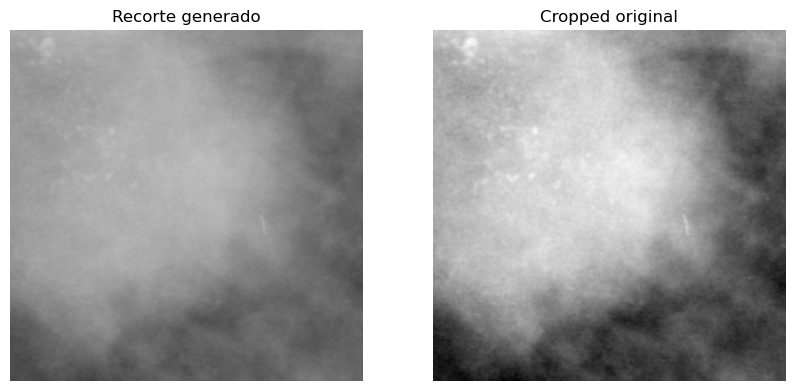


🖼️ Mostrando imagen 1...


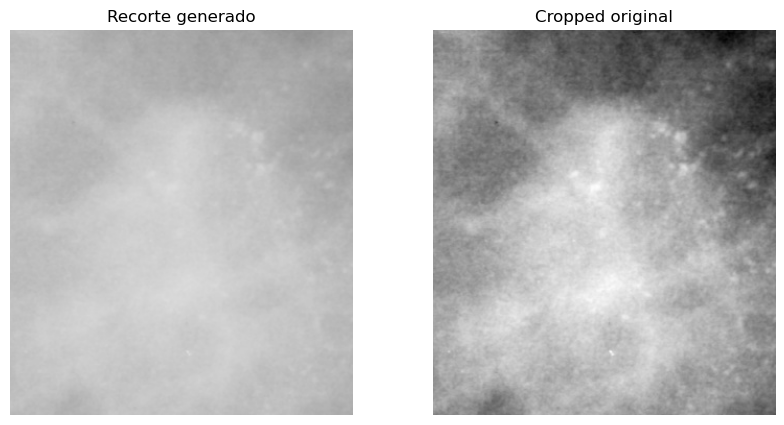


🖼️ Mostrando imagen 2...


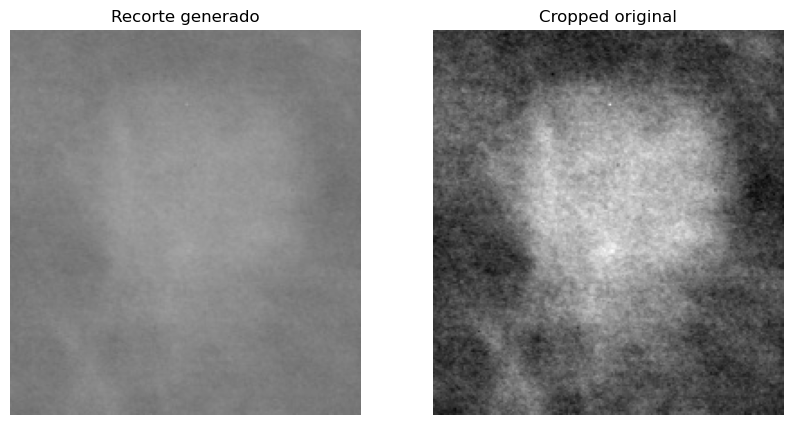


🖼️ Mostrando imagen 3...


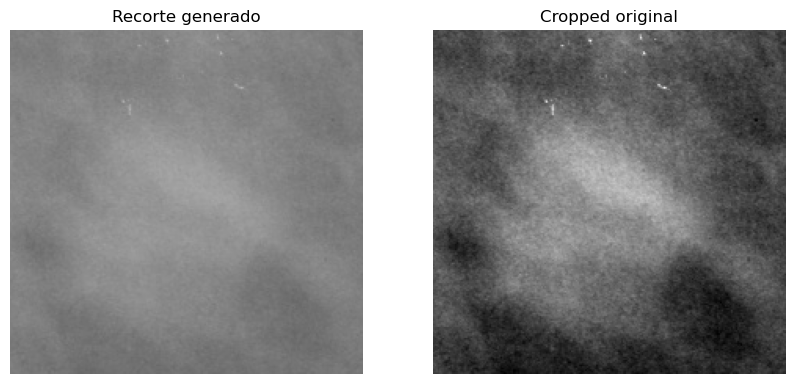


🖼️ Mostrando imagen 4...


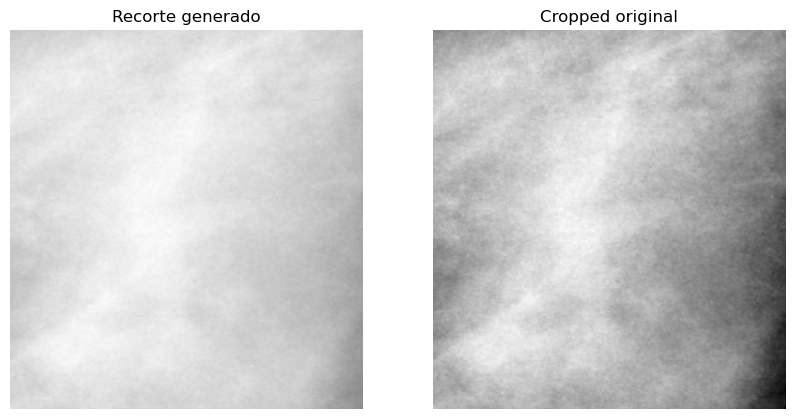

In [69]:
# Mostrar recorte vs cropped para las 5 primeras imágenes
for i, fila in mass_train_data.head(5).iterrows():
    print(f"\n🖼️ Mostrando imagen {i}...")
    mostrar_recorte_vs_cropped(
        fila['image file path'],
        fila['cropped image file path'],
        fila['x_min'],
        fila['y_min'],
        fila['x_max'],
        fila['y_max']
    )


In [24]:
mass_train_data.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                             cropped image file path  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   

                                  ROI mask file path   x_min   y_min   x_max  \
0  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   250.0  2402.0   681.0   
1  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   251.0  2960.0   507.0   
2  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1397.0  3480.0  1820.0   
3  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...  1633.0  3035.0  2055.0   
4  C:\Users\Itziar\Documents\Documentos\TFG-INF-D...   674.0  3784.0  1139.0   

    y_max  
0  2917.0  
1  3252.0  
2  3946.0  
3  3462.0  
4  4183.0

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_cropped_roi(image_path, cropped_path, roi_map_path):
    """
    Muestra la imagen original, el recorte cargado y el recorte generado por ROI map.

    Args:
        image_path (str): Ruta de la imagen original.
        cropped_path (str): Ruta del recorte ya existente.
        roi_map_path (str): Ruta del ROI map (binario o máscara 0/255).
    """
    # --- Cargar imagen original ---
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {image_path}")
    
    # --- Cargar cropped image ---
    crop_loaded = cv2.imread(cropped_path, cv2.IMREAD_GRAYSCALE)
    if crop_loaded is None:
        raise FileNotFoundError(f"No se encontró la cropped image: {cropped_path}")
    
    # --- Cargar ROI map y crear recorte ---
    roi_map = cv2.imread(roi_map_path, cv2.IMREAD_GRAYSCALE)
    if roi_map is None:
        raise FileNotFoundError(f"No se encontró el ROI map: {roi_map_path}")
    
    _, roi_bin = cv2.threshold(roi_map, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(roi_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No se encontró ROI en el mapa proporcionado")
    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi_crop = img[y:y+h, x:x+w]
    
    # --- Mostrar las tres imágenes ---
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Imagen completa')
    plt.axis('off')  # <--- Corrección aquí
    
    plt.subplot(1,3,2)
    plt.imshow(crop_loaded, cmap='gray')
    plt.title('Cropped image existente')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(roi_crop, cmap='gray')
    plt.title('Cropped image desde ROI map')
    plt.axis('off')
    
    plt.show()


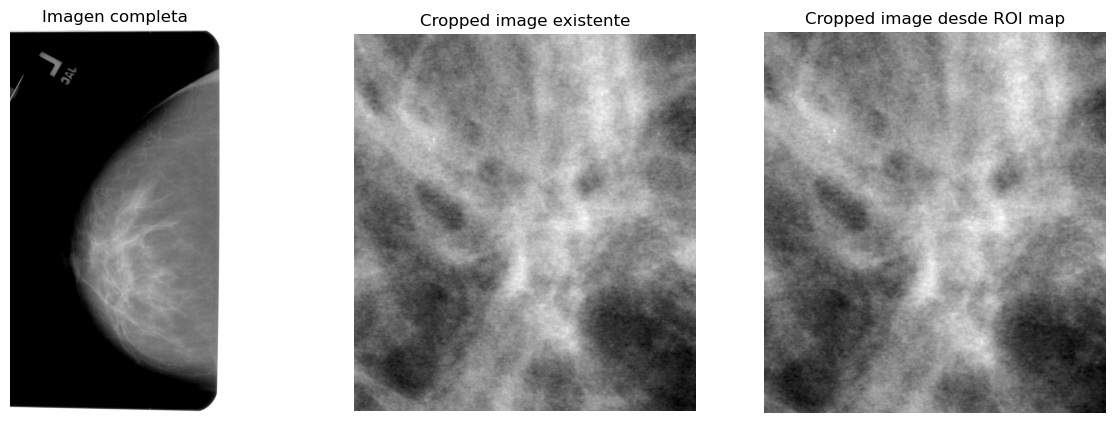

In [38]:
image_path = mass_train_data.iloc[2, mass_train_data.columns.get_loc('image file path')]
roi_path   = mass_train_data.iloc[2, mass_train_data.columns.get_loc('ROI mask file path')]
cropped_path = mass_train_data.iloc[2, mass_train_data.columns.get_loc('cropped image file path')]


show_image_with_cropped_roi(image_path,cropped_path,roi_path)

In [8]:
import cv2
import matplotlib.pyplot as plt

def compare_crop_with_bbox_df(image_path, cropped_path, x_min, y_min, x_max, y_max):
    """
    Genera un recorte a partir de las coordenadas del bounding box (x_min, y_min, x_max, y_max)
    y lo compara visualmente con la cropped image existente.

    Args:
        image_path (str): Ruta de la imagen completa.
        cropped_path (str): Ruta del recorte existente.
        x_min, y_min, x_max, y_max (int): Coordenadas de la bounding box.
    """
    # Cargar imágenes
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    crop_loaded = cv2.imread(cropped_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {image_path}")
    if crop_loaded is None:
        raise FileNotFoundError(f"No se encontró la cropped image: {cropped_path}")

    # Asegurar límites válidos dentro de la imagen
    h, w = img.shape
    x_min = max(0, int(x_min))
    y_min = max(0, int(y_min))
    x_max = min(w, int(x_max))
    y_max = min(h, int(y_max))

    # Generar el recorte desde las coordenadas
    generated_crop = img[y_min:y_max, x_min:x_max]

    # Mostrar comparación
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(crop_loaded, cmap='gray')
    plt.title("Cropped image existente")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(generated_crop, cmap='gray')
    plt.title("Recorte generado desde bounding box (df)")
    plt.axis('off')

    plt.show()

    return generated_crop



🔹 Mostrando caso 0...



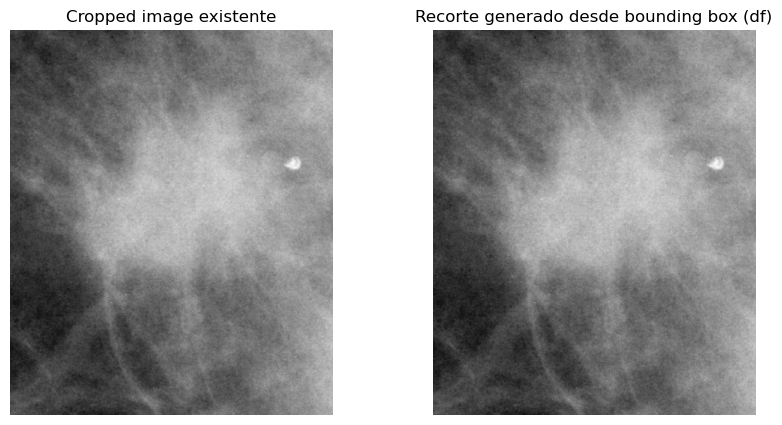


🔹 Mostrando caso 1...



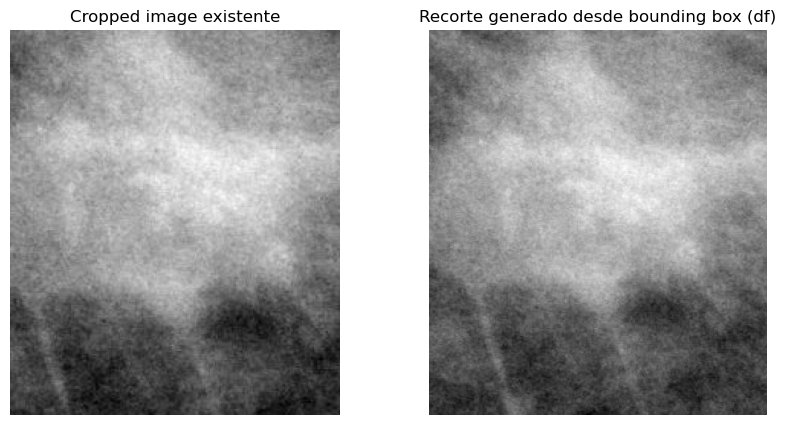


🔹 Mostrando caso 2...



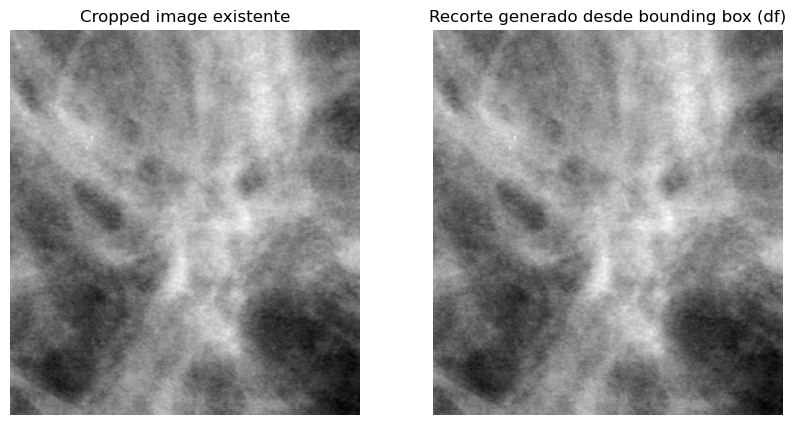


🔹 Mostrando caso 3...



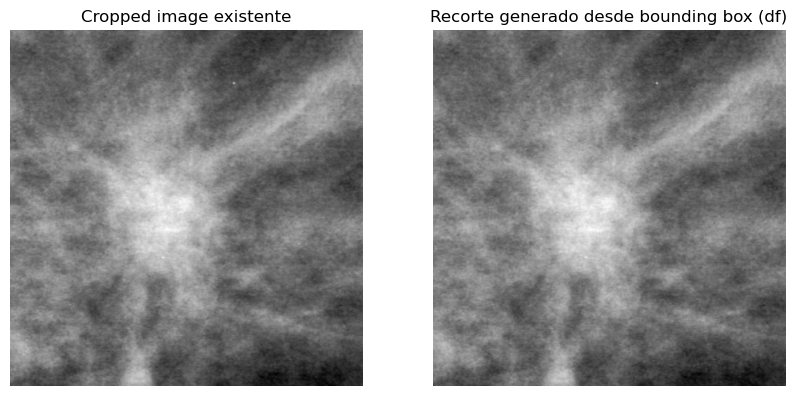


🔹 Mostrando caso 4...



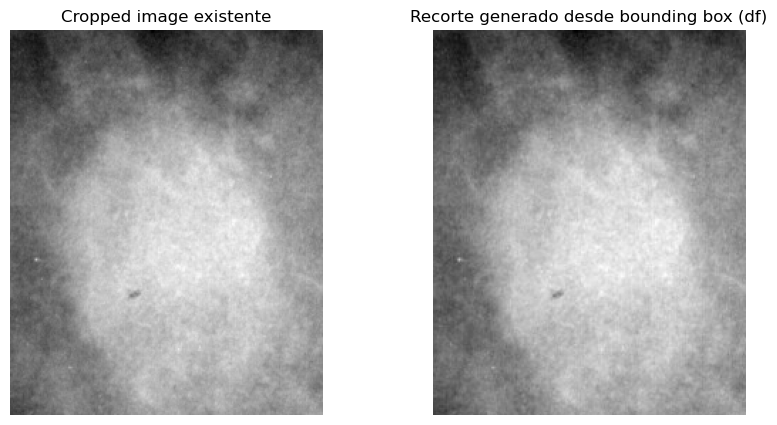

In [ ]:
# Ejecutar la comparación en 5 ejemplos del DataFrame
for i in range(5):
    print(f"\n🔹 Mostrando caso {i}...\n")

    image_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('image file path')]
    cropped_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('cropped image file path')]
    roi_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('ROI mask file path')]
    x_min = mass_train_data.iloc[i, mass_train_data.columns.get_loc('x_min')]
    y_min = mass_train_data.iloc[i, mass_train_data.columns.get_loc('y_min')]
    x_max = mass_train_data.iloc[i, mass_train_data.columns.get_loc('x_max')]
    y_max = mass_train_data.iloc[i, mass_train_data.columns.get_loc('y_max')]

    show_image_with_cropped_roi(image_path,cropped_path,roi_path)



🔹 Mostrando caso 0...



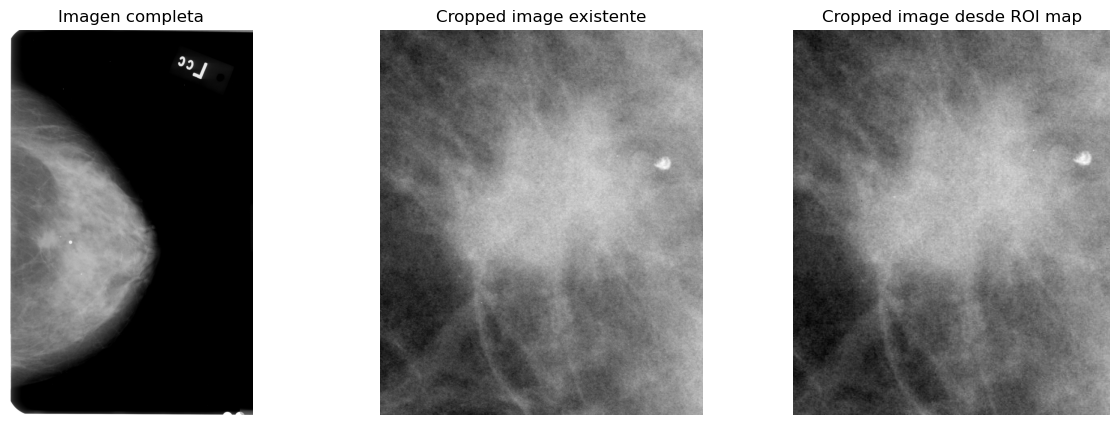


🔹 Mostrando caso 1...



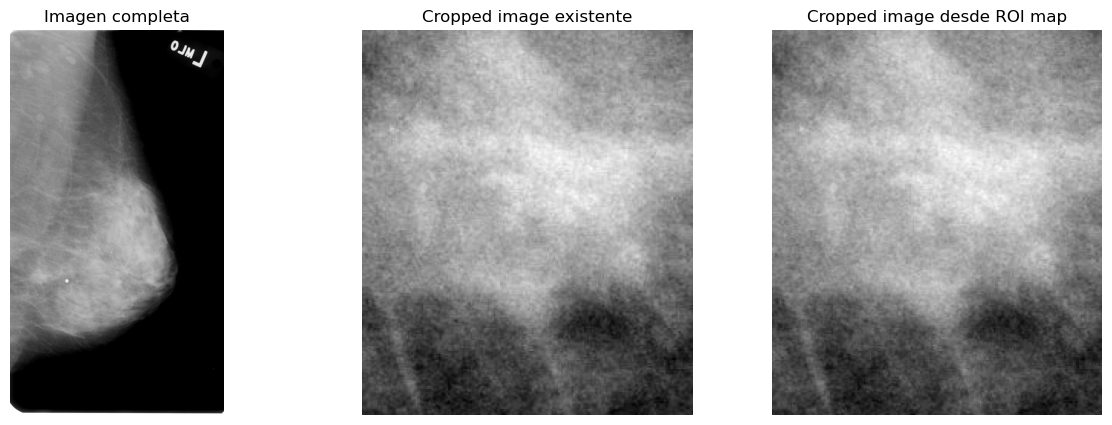


🔹 Mostrando caso 2...



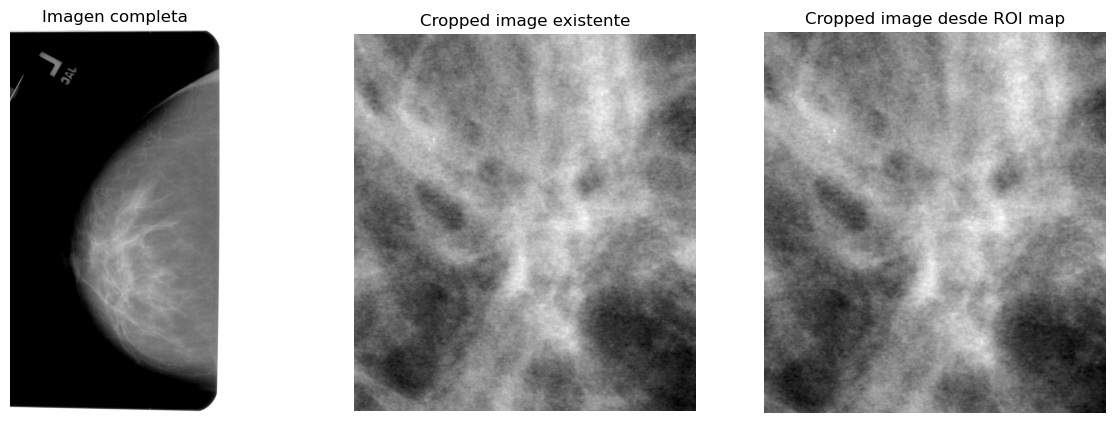


🔹 Mostrando caso 3...



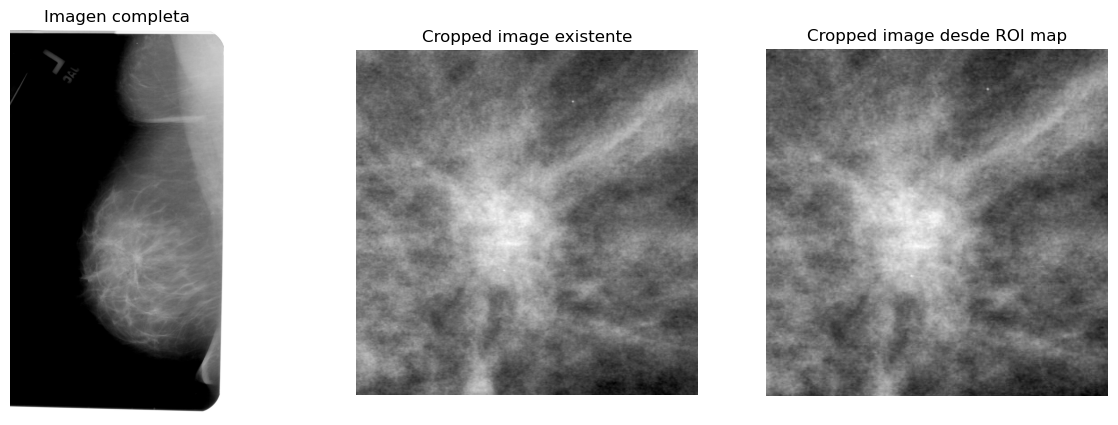


🔹 Mostrando caso 4...



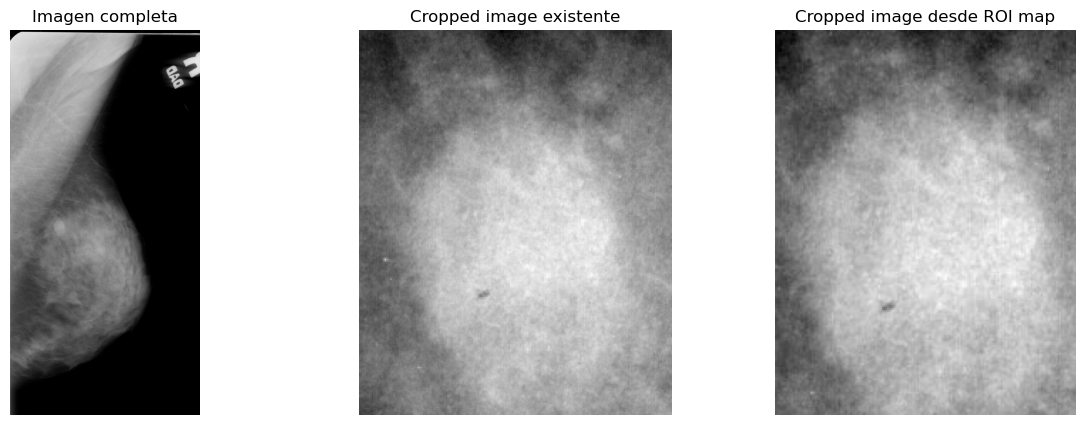

In [ ]:
# Ejecutar la comparación en 5 ejemplos del DataFrame
for i in range(5):
    print(f"\n🔹 Mostrando caso {i}...\n")
    image_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('image file path')]
    cropped_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('C')]
    roi_path = mass_train_data.iloc[i, mass_train_data.columns.get_loc('ROI mask file path')]
    show_image_with_cropped_roi(image_path,cropped_path,roi_path)
